In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create logger
logger = logging.getLogger('data_exploration')


In [6]:
def load_datasets():
    """Load all datasets from the datasets folder"""
    logger.info("Loading datasets into pandas dataframes...")
    users_df = pd.read_csv('datasets/users.csv')
    items_df = pd.read_csv('datasets/items.csv')
    events_df = pd.read_csv('datasets/events.csv')

    return users_df, items_df, events_df

users_df, items_df, events_df = load_datasets()
users_df.head(), items_df.head(), events_df.head()

2025-02-23 17:18:28 - INFO - Loading datasets into pandas dataframes...


(   user_id country
 0        0     USA
 1        1     USA
 2        2   Italy
 3        3   Japan
 4        4   Italy,
    item_id category    hair   eyes
 0        0    flirt     red   blue
 1        1    dance   brown   blue
 2        2       dj     red  brown
 3        3    flirt  blonde  brown
 4        4       dj     red  brown,
    user_id  item_id   timestamp
 0        0       34  1607590072
 1        0       26  1607590260
 2        0      187  1607590503
 3        0       86  1607591006
 4        0      111  1607591526)

In [15]:
def plot_histogram(data, xlabel = "Session Length (minutes)", ylabel = "Frequency",title = "Distribution of Session Lengths"):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=10, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)

    # Add mean and median lines
    plt.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {data.mean():.2f} mins')
    plt.axvline(data.median(), color='green', linestyle='dashed', linewidth=1, label=f'Median: {data.median():.2f} mins')
    plt.legend()
    plt.show()

    # Show some basic statistics
    logger.info("Session Length Statistics:")
    print(data.describe())

In [8]:
def remove_duplicates(df):
    """Remove duplicates items with the same session keeping the first records by time"""
    df = (df.sort_values(['user_id', 'session_id', 'timestamp', 'item_id'])
          .drop_duplicates(subset=['user_id', 'session_id', 'item_id'], keep='first')
          .reset_index(drop=True))
    return df

def filter_multievent_sessions(df):

    # Count events per session
    session_counts = df.groupby(['user_id', 'session_id']).size().reset_index(name='event_count')

    # Filter out sessions with only one event
    df = df.merge(session_counts, on=['user_id', 'session_id'])
    df = df[df['event_count'] > 1].drop(columns=['event_count'])
    
    return df


def process_sessions(events):
    
    # Convert timestamp to datetime
    events['datetime'] = pd.to_datetime(events['timestamp'], unit='s')
    # Sort by user_id and timestamp
    events = events.sort_values(by=["user_id", "timestamp"])

    # Calculate time difference between consecutive events
    events['hours_since_last'] = events.groupby('user_id')['datetime'].diff().dt.total_seconds() / 3600

    # Identify new sessions (time_diff > 8 hours)
    events['new_session'] = (events['hours_since_last'] >= 8 ).fillna(True)

    # Assign session IDs
    events['session_counter'] = events.groupby('user_id')['new_session'].cumsum()
    events['session_id'] = events['user_id'].astype(str)+'-'+events['session_counter'].astype(str)

    events = remove_duplicates(events)
    events = filter_multievent_sessions(events)

    # Adding bounce flag column
    events['bounce_flag'] = (events.groupby('session_id')['datetime']
                            .transform('max') == events['datetime']).astype(int)

    return events

In [9]:
events_dedup = process_sessions(events_df)
events_dedup

,user_id,item_id,timestamp,datetime,hours_since_last,new_session,session_counter,session_id,bounce_flag
0,0,34,1607590072,2020-12-10 08:47:52,NaN,False,0,0-0,0
1,0,26,1607590260,2020-12-10 08:51:00,0.052222,False,0,0-0,0
2,0,187,1607590503,2020-12-10 08:55:03,0.067500,False,0,0-0,0
3,0,86,1607591006,2020-12-10 09:03:26,0.139722,False,0,0-0,0
4,0,111,1607591526,2020-12-10 09:12:06,0.144444,False,0,0-0,0
...,...,...,...,...,...,...,...,...,...
15103,499,10,1608042115,2020-12-15 14:21:55,0.120278,False,2,499-2,0
15104,499,76,1608042367,2020-12-15 14:26:07,0.070000,False,2,499-2,0
15105,499,99,1608042850,2020-12-15 14:34:10,0.134167,False,2,499-2,0
15106,499,198,1608043346,2020-12-15 14:42:26,0.137778,False,2,499-2,0


### Total Number of sessions:

In [10]:
print("Total number of sessions with multiple events in a session: ",len(events_dedup.groupby('session_id')))

Total number of sessions with multiple events in a session:  1026


### Average number of events per session:

In [11]:
print("\n Average number of events per session: ",events_dedup.groupby('session_id')['item_id'].count().mean().round(2))



 Average number of events per session:  14.69


### Histogram of session lengths

2025-02-23 17:31:37 - INFO - 3. Plotting histogram of session lengths in minutes...


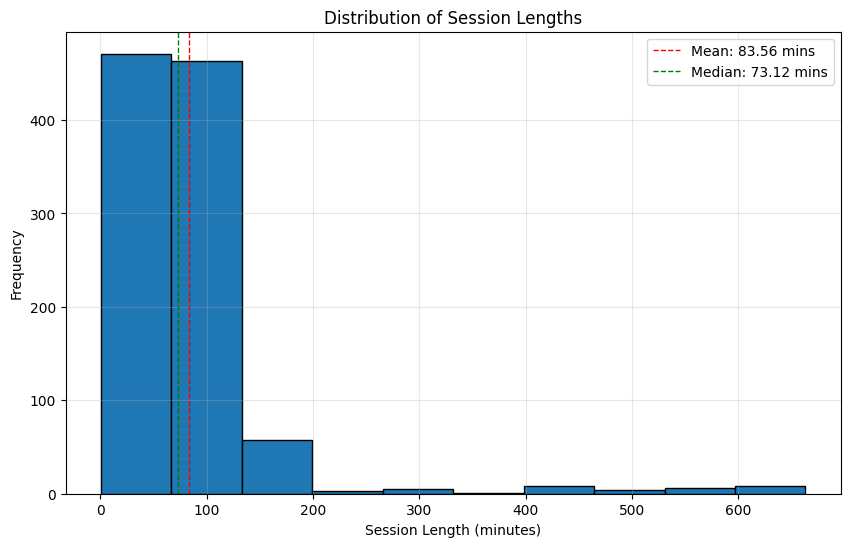

2025-02-23 17:31:37 - INFO - Session Length Statistics:


count    1026.000000
mean       83.559552
std        85.400003
min         0.466667
25%        36.275000
50%        73.116667
75%       107.220833
max       663.083333
dtype: float64


In [16]:
session_lengths = (events_dedup.groupby('session_id')['datetime']
                  .agg(['min', 'max'])
                  .apply(lambda x: (x['max'] - x['min']).total_seconds() / 60, axis=1))
logger.info("3. Plotting histogram of session lengths in minutes...")
plot_histogram(session_lengths)

2025-02-23 17:31:46 - INFO - Plotting histogram of session lengths in hours...


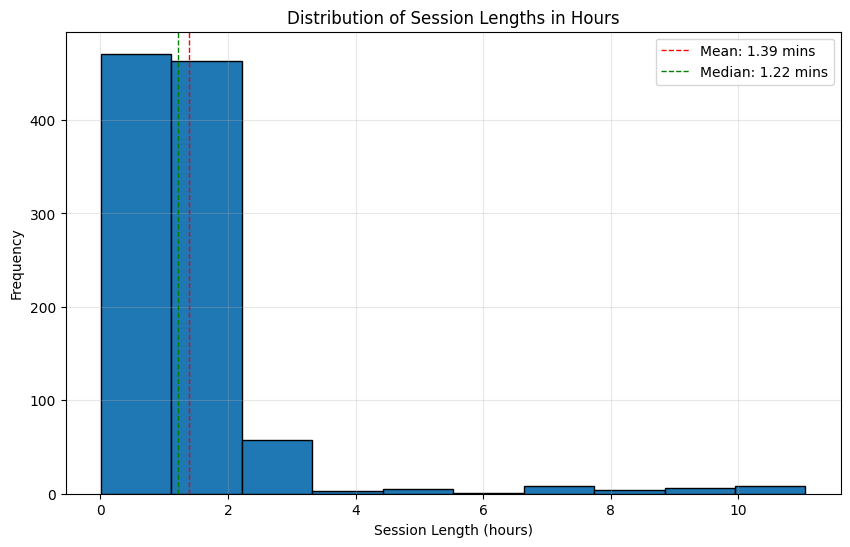

2025-02-23 17:31:46 - INFO - Session Length Statistics:


count    1026.000000
mean        1.392659
std         1.423333
min         0.007778
25%         0.604583
50%         1.218611
75%         1.787014
max        11.051389
dtype: float64


In [17]:
# Calculate session length (in hours)
session_lengths = (events_dedup.groupby('session_id')['datetime']
                  .agg(['min', 'max'])
                  .apply(lambda x: (x['max'] - x['min']).total_seconds() / 3600, axis=1))
logger.info("Plotting histogram of session lengths in hours...")
plot_histogram(session_lengths, xlabel = "Session Length (hours)", title = "Distribution of Session Lengths in Hours")

### Category with highest bounce rate

In [19]:
logger.info("4. Calculating the category with highest bounce rate...")
bounce_items = events_dedup.loc[(events_dedup["bounce_flag"] == 1),'item_id'].value_counts().reset_index(name="N_bounces")
bounce_cate = bounce_items.merge(items_df, on="item_id").groupby('category')['N_bounces'].sum().reset_index(name="Total_N_bounces")
bounce_cate = bounce_cate.sort_values("Total_N_bounces", ascending=False).reset_index(drop=True)
print(bounce_cate)
logger.info(f"The category with highest bounce rate is: {bounce_cate.iloc[0]['category']}")


2025-02-23 17:32:28 - INFO - 4. Calculating the category with highest bounce rate...
2025-02-23 17:32:28 - INFO - The category with highest bounce rate is: flirt


  category  Total_N_bounces
0    flirt              355
1    dance              353
2       dj              318


### Country with highest average visits per user

In [20]:
logger.info("5. Country with highest average visits per user...")
user_visits = events_dedup.groupby('user_id')['session_counter'].max().reset_index(name="n_visits")
avg_visit_by_country = user_visits.merge(users_df, on="user_id").groupby("country")['n_visits'].mean().reset_index(name = 'avg_n_visits')
avg_visit_by_country = avg_visit_by_country.sort_values("avg_n_visits", ascending=False).reset_index(drop=True)
print(avg_visit_by_country)
logger.info(f"The country with highest average visits per user is: {avg_visit_by_country.iloc[0]['country']}")

2025-02-23 17:32:47 - INFO - 5. Country with highest average visits per user...
2025-02-23 17:32:47 - INFO - The country with highest average visits per user is: Japan


   country  avg_n_visits
0    Japan      1.883721
1    Italy      1.822581
2  Germany      1.802817
3   France      1.578947
4      USA      1.508475
5  Belgium      1.489796
6    India      1.481481


### Performer with most number of visits by each category

In [23]:
logger.info("6. Performer with most number of visits by each category...")
top_performers = events_dedup.merge(items_df, on="item_id").groupby(['category','item_id'])['item_id'].count().reset_index(name="N_visits")
top_performers = top_performers.sort_values('N_visits', ascending=False).groupby('category').head(1).reset_index(drop=True)
logger.info(f"The performer with most number of visits by each category is: ")
print(top_performers)

2025-02-23 17:33:23 - INFO - 6. Performer with most number of visits by each category...
2025-02-23 17:33:23 - INFO - The performer with most number of visits by each category is: 


  category  item_id  N_visits
0    dance      131       173
1       dj        7       173
2    flirt      155       170


### Model Training


In [26]:
# Calculate average sessions per day
daily_sessions = events_dedup.groupby(events_dedup['datetime'].dt.date)['session_id'].nunique().reset_index()
daily_sessions.columns = ['date', 'num_sessions'] 
avg_sessions_per_day = daily_sessions['num_sessions'].mean()

logger.info("7. Average number of sessions per day...")
logger.info(f"Average number of sessions per day: {avg_sessions_per_day:.2f}")
print("\nDaily sessions breakdown:")
print(daily_sessions)


2025-02-23 18:12:50 - INFO - 7. Average number of sessions per day...
2025-02-23 18:12:50 - INFO - Average number of sessions per day: 51.57



Daily sessions breakdown:
          date  num_sessions
0   2020-12-09            59
1   2020-12-10            94
2   2020-12-11           120
3   2020-12-12           121
4   2020-12-13            96
5   2020-12-14           102
6   2020-12-15            82
7   2020-12-16            63
8   2020-12-17            78
9   2020-12-18            61
10  2020-12-19            46
11  2020-12-20            39
12  2020-12-21            36
13  2020-12-22            38
14  2020-12-23            11
15  2020-12-24            15
16  2020-12-25             7
17  2020-12-26             9
18  2020-12-27             3
19  2020-12-28             2
20  2020-12-29             1


the data given is observed from 2020-12-09 to 2020-12-29.

lets consider records until 2020-12-24 for training model and test on the last 5 days for the model performance


In [28]:
from itertools import combinations
from collections import defaultdict

In [29]:
training_data = events_dedup[events_dedup['datetime'] < '2020-12-24']
session_train = training_data.groupby('session_id')['item_id'].apply(list)

# Create co-occurrence matrix
co_occurrence = defaultdict(lambda: defaultdict(int))
for items in session_train:
    for item1, item2 in combinations(set(items), 2):  # Get unique pairs of items
        co_occurrence[item1][item2] += 1
        co_occurrence[item2][item1] += 1

# Convert to DataFrame for easier manipulation
co_occurrence_df = pd.DataFrame(co_occurrence).fillna(0)
co_occurrence_df

,3,138,141,14,143,151,26,29,34,38,...,24,108,22,142,18,189,107,1,43,74
138,3.0,0.0,3.0,6.0,3.0,2.0,5.0,4.0,1.0,2.0,...,2.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0
141,6.0,3.0,0.0,4.0,4.0,9.0,9.0,4.0,3.0,6.0,...,4.0,1.0,2.0,3.0,4.0,3.0,2.0,4.0,3.0,4.0
14,3.0,6.0,4.0,0.0,6.0,10.0,11.0,1.0,8.0,4.0,...,6.0,3.0,1.0,3.0,6.0,4.0,4.0,3.0,1.0,2.0
143,5.0,3.0,4.0,6.0,0.0,6.0,5.0,3.0,5.0,4.0,...,5.0,4.0,2.0,4.0,11.0,4.0,1.0,3.0,2.0,8.0
151,14.0,2.0,9.0,10.0,6.0,0.0,20.0,10.0,11.0,12.0,...,16.0,7.0,6.0,9.0,12.0,6.0,4.0,3.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1.0,5.0,4.0,4.0,0.0,8.0,5.0,4.0,2.0,4.0,...,1.0,2.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0,2.0
3,0.0,3.0,6.0,3.0,5.0,14.0,9.0,7.0,10.0,8.0,...,10.0,6.0,8.0,5.0,11.0,5.0,5.0,3.0,4.0,5.0
17,0.0,2.0,3.0,2.0,6.0,5.0,3.0,6.0,1.0,5.0,...,3.0,1.0,1.0,2.0,5.0,3.0,1.0,2.0,2.0,1.0
78,0.0,3.0,4.0,2.0,4.0,9.0,1.0,3.0,2.0,4.0,...,2.0,3.0,3.0,4.0,1.0,2.0,1.0,2.0,2.0,0.0


In [30]:
# Normalize co-occurrence matrix to compute similarity scores
similarity_matrix = co_occurrence_df.copy()
for item in similarity_matrix.columns:
    norm_factor = np.sqrt(similarity_matrix[item].sum())
    similarity_matrix[item] /= norm_factor

In [31]:
#  Test data:
test_data = events_dedup[events_dedup['datetime'] >= '2020-12-24']
session_test = test_data.groupby('session_id')['item_id'].apply(list)
session_test

session_id
156-4    [31, 156, 46, 161, 197, 193, 131, 84, 124, 61,...
163-3    [3, 182, 91, 92, 147, 132, 90, 112, 83, 58, 12...
166-3    [10, 126, 25, 91, 7, 167, 45, 171, 123, 8, 31,...
174-2                          [186, 3, 41, 7, 70, 9, 119]
177-4        [155, 122, 63, 173, 108, 77, 8, 167, 92, 117]
177-5    [131, 96, 167, 168, 123, 196, 101, 71, 16, 98,...
181-4    [127, 76, 5, 152, 7, 24, 72, 77, 56, 71, 69, 1...
183-5                                [12, 44, 79, 132, 28]
20-2     [66, 142, 33, 1, 160, 162, 171, 32, 65, 161, 1...
20-3     [13, 56, 173, 21, 16, 176, 61, 143, 151, 167, ...
226-5    [102, 163, 191, 123, 124, 139, 179, 169, 79, 1...
234-2    [99, 64, 115, 28, 61, 19, 66, 155, 47, 180, 69...
243-3    [30, 84, 13, 76, 49, 69, 155, 59, 193, 166, 94...
253-3    [188, 21, 72, 127, 73, 160, 58, 3, 117, 91, 93...
256-3               [150, 36, 101, 3, 155, 47, 93, 86, 77]
272-3    [156, 41, 101, 66, 191, 7, 90, 81, 47, 164, 5,...
28-3              [89, 188, 99, 194, 93, 173,

In [37]:
def recommend_items(input_items, similarity_matrix, top_n=5):
    # Initialize scores dictionary
    scores = defaultdict(float)
    
    # For each candidate item (all items in the similarity matrix)
    for candidate_item in similarity_matrix.columns:
        if candidate_item not in input_items:  # Exclude input items
            # Calculate the total co-occurrence score with all input items
            total_score = 0
            for input_item in input_items:
                if input_item in similarity_matrix.columns:
                    # Add the similarity score between input_item and candidate_item
                    total_score += similarity_matrix.loc[candidate_item, input_item]
            
            # Store the total score for this candidate item
            scores[candidate_item] = total_score
    
    # Sort by aggregated scores and return top N recommendations
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, score in sorted_scores[:top_n]]

Lets take a few sessions from the test data and randomly select a combination of 3 items and see the recommendations and check with the rest of the events of the same session

In [47]:
# Example usage
input_items = [164, 69, 132]  # Items consumed in the current session
recommendations = recommend_items(input_items, similarity_matrix)
print("Recommended Items:", recommendations)

Recommended Items: [99, 101, 155, 15, 171]


In [36]:
print(session_test['417-3'])

[89, 155, 9, 15, 137, 64, 151, 115, 101, 119, 162, 7, 82, 11, 26, 71, 122, 164, 69, 132, 88, 59]


In [ ]:
464-4                               [154, 119, 141, 2, 26]

### Weighter recommendations

In [41]:
# Step 1: Calculate N_visits per item
item_visits = training_data['item_id'].value_counts().reset_index(name='N_visits')
# item_visits.columns = ['item_id', 'N_visits']

# Step 2: Merge with items dataset to get category and N_visits
items_with_weights = items_df.merge(item_visits, on='item_id', how='left')

# Step 3: Create weight mapping (example using N_visits)
# Normalize N_visits to get weights between 0 and 1
items_with_weights['weight'] = items_with_weights['N_visits'] / items_with_weights['N_visits'].max()

# Alternatively, if using category weights:
category_weights = {'dance': 1.2, 'flirt': 1.0, 'dj': 1.4}
items_with_weights['weight'] = items_with_weights['category'].map(category_weights)

# Step 4: Create a weight dictionary for quick lookup
weight_dict = dict(zip(items_with_weights['item_id'], items_with_weights['weight']))

# Step 5: Modify co-occurrence matrix creation to include weights
co_occurrence_weighted = defaultdict(lambda: defaultdict(float))  # Use float for weighted counts

for items_in_session in session_train:
    unique_items = set(items_in_session)
    for item1, item2 in combinations(unique_items, 2):
        # Get weights for both items
        weight1 = weight_dict.get(item1, 1.0)  # Default to 1.0 if weight not found
        weight2 = weight_dict.get(item2, 1.0)
        
        # Calculate weighted co-occurrence
        weighted_count = (weight1 + weight2) / 2  # Average of both weights
        
        # Update co-occurrence matrix
        co_occurrence_weighted[item1][item2] += weighted_count
        co_occurrence_weighted[item2][item1] += weighted_count

# Convert to DataFrame
co_occurrence_weighted_df = pd.DataFrame(co_occurrence_weighted).fillna(0)

In [42]:
# Normalize co-occurrence matrix to compute similarity scores
w_similarity_matrix = co_occurrence_weighted_df.copy()
for item in w_similarity_matrix.columns:
    norm_factor = np.sqrt(w_similarity_matrix[item].sum())
    w_similarity_matrix[item] /= norm_factor

In [46]:
# Example usage
input_items = [164, 69, 132] 
recommendations = recommend_items(input_items, w_similarity_matrix)
print("Recommended Items:", recommendations)

Recommended Items: [99, 101, 15, 7, 131]


In [43]:
print(session_test['417-3'])

[89, 155, 9, 15, 137, 64, 151, 115, 101, 119, 162, 7, 82, 11, 26, 71, 122, 164, 69, 132, 88, 59]
